In [11]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [12]:
def load_evaluation_summary(summary_file="/data/jane/math_gender/2_answer_math_qs/evaluation_results/evaluation_summary.json"):
    """Load the evaluation summary JSON file."""
    with open(summary_file, 'r') as f:
        return json.load(f)

summary_data = load_evaluation_summary()
print(f"Loaded {len(summary_data)} evaluation results")

Loaded 76 evaluation results


In [13]:
def parse_results(summary_data):
    """Parse summary data into a structured DataFrame."""
    records = []
    
    for key, metadata in summary_data.items():
        # Parse key format: "model_context"
        # Handle special cases like gpt-4o and other models with hyphens
        
        # Check for no_context first (special case)
        if key.endswith('_no_context'):
            model = key[:-len('_no_context')]
            context = 'no_context'
            records.append({
                'model': model,
                'context': context,
                'accuracy': metadata['accuracy'],
                'correct_answers': metadata['correct_answers'],
                'total_questions': metadata['total_questions']
            })
            continue
        
        # Try to extract context by checking against known contexts
        context = None
        model = None
        
        # Define all possible contexts
        all_contexts = [
            'cooking', 'gardening', 'fashion', 'dance', 'baking', 
            'makeup', 'shopping', 'romance novels', 'knitting',
            'construction', 'sports', 'video games', 'cars', 'weightlifting',
            'finance', 'fishing', 'woodworking', 'hiking'
        ]
        
        # Check if key ends with any known context
        for ctx in all_contexts:
            if key.endswith('_' + ctx):
                context = ctx
                model = key[:-len('_' + ctx)]
                break
        
        # Handle "romance novels" special case with space
        if context is None and key.endswith('_romance_novels'):
            context = 'romance novels'
            model = key[:-len('_romance_novels')]
        
        # Handle "video games" special case with space
        if context is None and key.endswith('_video_games'):
            context = 'video games'
            model = key[:-len('_video_games')]
        
        if model is None or context is None:
            print(f"Warning: Could not parse key: {key}")
            continue
            
        records.append({
            'model': model,
            'context': context,
            'accuracy': metadata['accuracy'],
            'correct_answers': metadata['correct_answers'],
            'total_questions': metadata['total_questions']
        })
    
    return pd.DataFrame(records)

df = parse_results(summary_data)
print(f"\nDataFrame shape: {df.shape}")
print(f"\nModels found: {df['model'].unique().tolist()}")
print(f"\nContexts found: {df['context'].unique().tolist()}")


DataFrame shape: (76, 5)

Models found: ['gpt-4o', 'qwen-coder', 'llama-4', 'deepseek-r1']

Contexts found: ['cars', 'baking', 'construction', 'cooking', 'dance', 'fashion', 'finance', 'fishing', 'gardening', 'hiking', 'knitting', 'makeup', 'romance novels', 'shopping', 'sports', 'video games', 'weightlifting', 'woodworking', 'no_context']


In [14]:
# First half: cooking - knitting (light pink)
first_half_contexts = [
    'cooking', 'gardening', 'fashion', 'dance', 'baking', 
    'makeup', 'shopping', 'romance novels', 'knitting'
]

# Second half: construction - hiking (light blue)
second_half_contexts = [
    'construction', 'sports', 'video games', 'cars', 'weightlifting',
    'finance', 'fishing', 'woodworking', 'hiking'
]

# Define colors
light_pink = '#FFB6C1'
light_blue = '#ADD8E6'
no_context_color = '#90EE90'  # Light green for no-context

def get_context_color(context):
    """Return color based on context group."""
    if context == 'no_context':
        return no_context_color
    elif context in first_half_contexts:
        return light_pink
    elif context in second_half_contexts:
        return light_blue
    else:
        return '#CCCCCC'  # Gray for unknown contexts

# Add color column
df['color'] = df['context'].apply(get_context_color)

In [15]:

# Cell 5: Create visualization function
def create_model_visualization(df, model_name, output_dir="evaluation_results/plots"):
    """Create accuracy visualization for a single model."""
    
    # Filter data for this model
    model_data = df[df['model'] == model_name].copy()
    
    if model_data.empty:
        print(f"No data found for model: {model_name}")
        return
    
    # Separate no_context from other contexts
    no_context_data = model_data[model_data['context'] == 'no_context']
    contextualized_data = model_data[model_data['context'] != 'no_context']
    
    # Sort contextualized data by context order
    all_contexts = first_half_contexts + second_half_contexts
    contextualized_data['context_order'] = contextualized_data['context'].apply(
        lambda x: all_contexts.index(x) if x in all_contexts else 999
    )
    contextualized_data = contextualized_data.sort_values('context_order')
    
    # Combine: no_context first, then all contextualized
    if not no_context_data.empty:
        model_data = pd.concat([no_context_data, contextualized_data], ignore_index=True)
    else:
        model_data = contextualized_data
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create bar plot
    bars = ax.bar(
        range(len(model_data)),
        model_data['accuracy'],
        color=model_data['color'],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )
    
    # Customize plot
    ax.set_xlabel('Context', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title(f'Model Performance: {model_name.upper()}', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(model_data)))
    ax.set_xticklabels(model_data['context'].str.replace('_', ' ').str.title(), 
                       rotation=45, ha='right')
    
    # Set y-axis limits
    ax.set_ylim(0, 100)
    
    # Add horizontal grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(model_data.iterrows()):
        height = row['accuracy']
        ax.text(i, height + 1.5, f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=no_context_color, edgecolor='black', label='No Context'),
        Patch(facecolor=light_pink, edgecolor='black', label='Group 1 (Cooking - Knitting)'),
        Patch(facecolor=light_blue, edgecolor='black', label='Group 2 (Construction - Hiking)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    # Add average lines
    if not no_context_data.empty:
        no_context_acc = no_context_data['accuracy'].iloc[0]
        ax.axhline(y=no_context_acc, color='green', linestyle=':', linewidth=2, 
                   alpha=0.7, label=f'No Context: {no_context_acc:.1f}%')
    
    contextualized_avg = contextualized_data['accuracy'].mean()
    ax.axhline(y=contextualized_avg, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Contextualized Avg: {contextualized_avg:.1f}%')
    
    # Update legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'{model_name}_accuracy_with_no_context.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {output_file}")
    
    return fig

Generating visualizations for 4 models...

Creating plot for: gpt-4o


/tmp/ipykernel_1227997/4281550073.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contextualized_data['context_order'] = contextualized_data['context'].apply(


Saved plot to: evaluation_results/plots/gpt-4o_accuracy_with_no_context.png


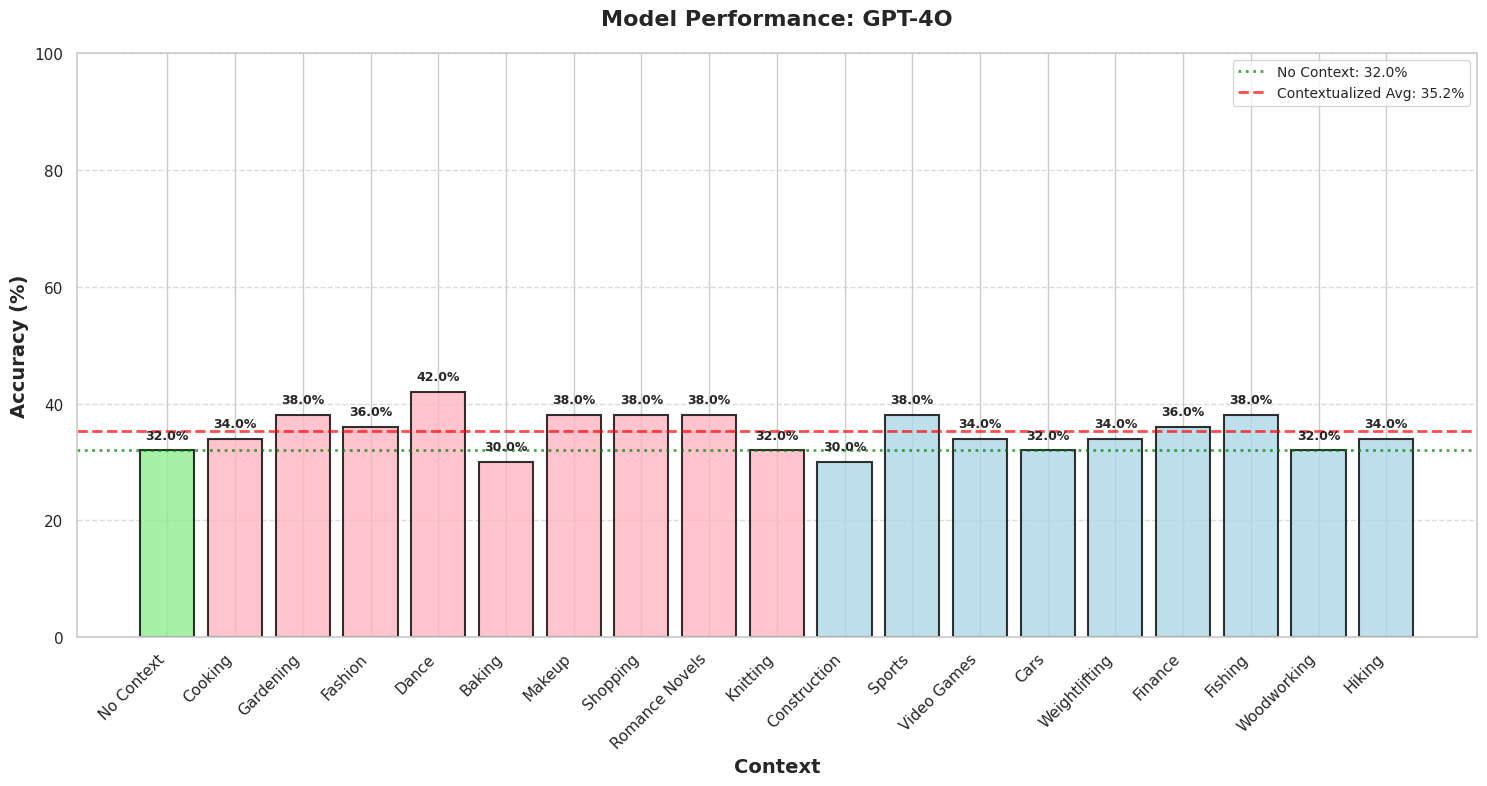


Creating plot for: qwen-coder


/tmp/ipykernel_1227997/4281550073.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contextualized_data['context_order'] = contextualized_data['context'].apply(


Saved plot to: evaluation_results/plots/qwen-coder_accuracy_with_no_context.png


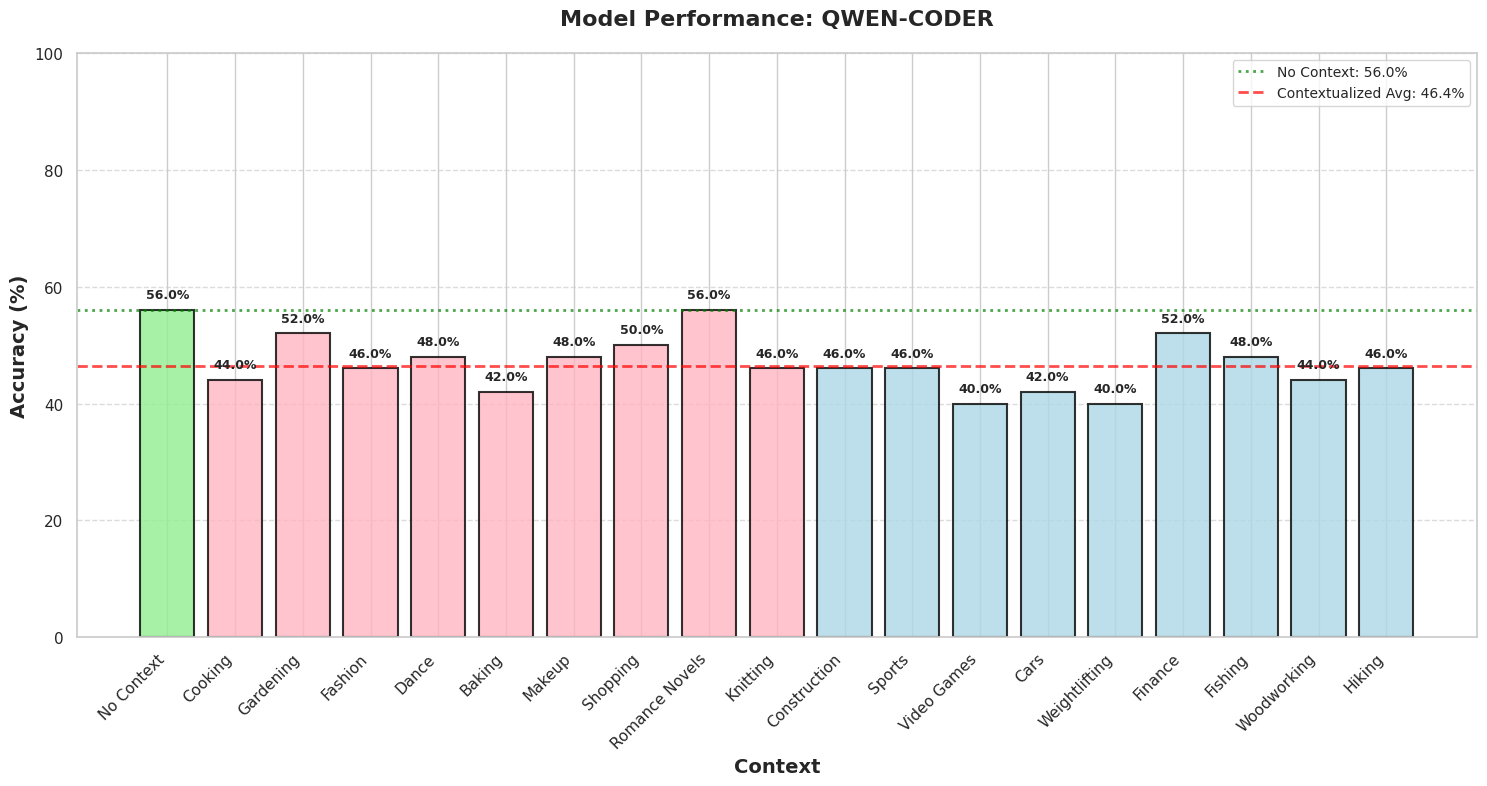


Creating plot for: llama-4


/tmp/ipykernel_1227997/4281550073.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contextualized_data['context_order'] = contextualized_data['context'].apply(


Saved plot to: evaluation_results/plots/llama-4_accuracy_with_no_context.png


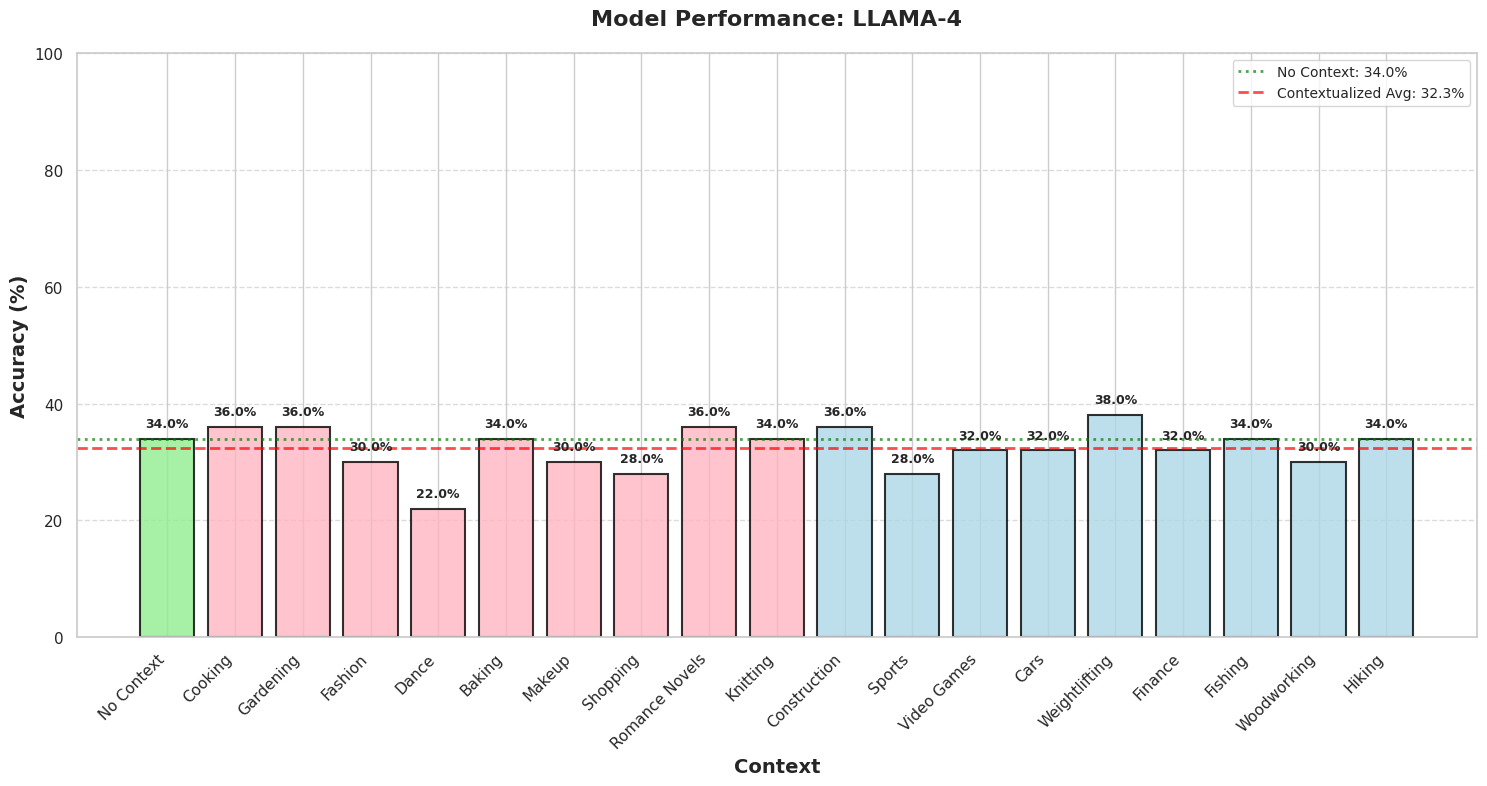


Creating plot for: deepseek-r1


/tmp/ipykernel_1227997/4281550073.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contextualized_data['context_order'] = contextualized_data['context'].apply(


Saved plot to: evaluation_results/plots/deepseek-r1_accuracy_with_no_context.png


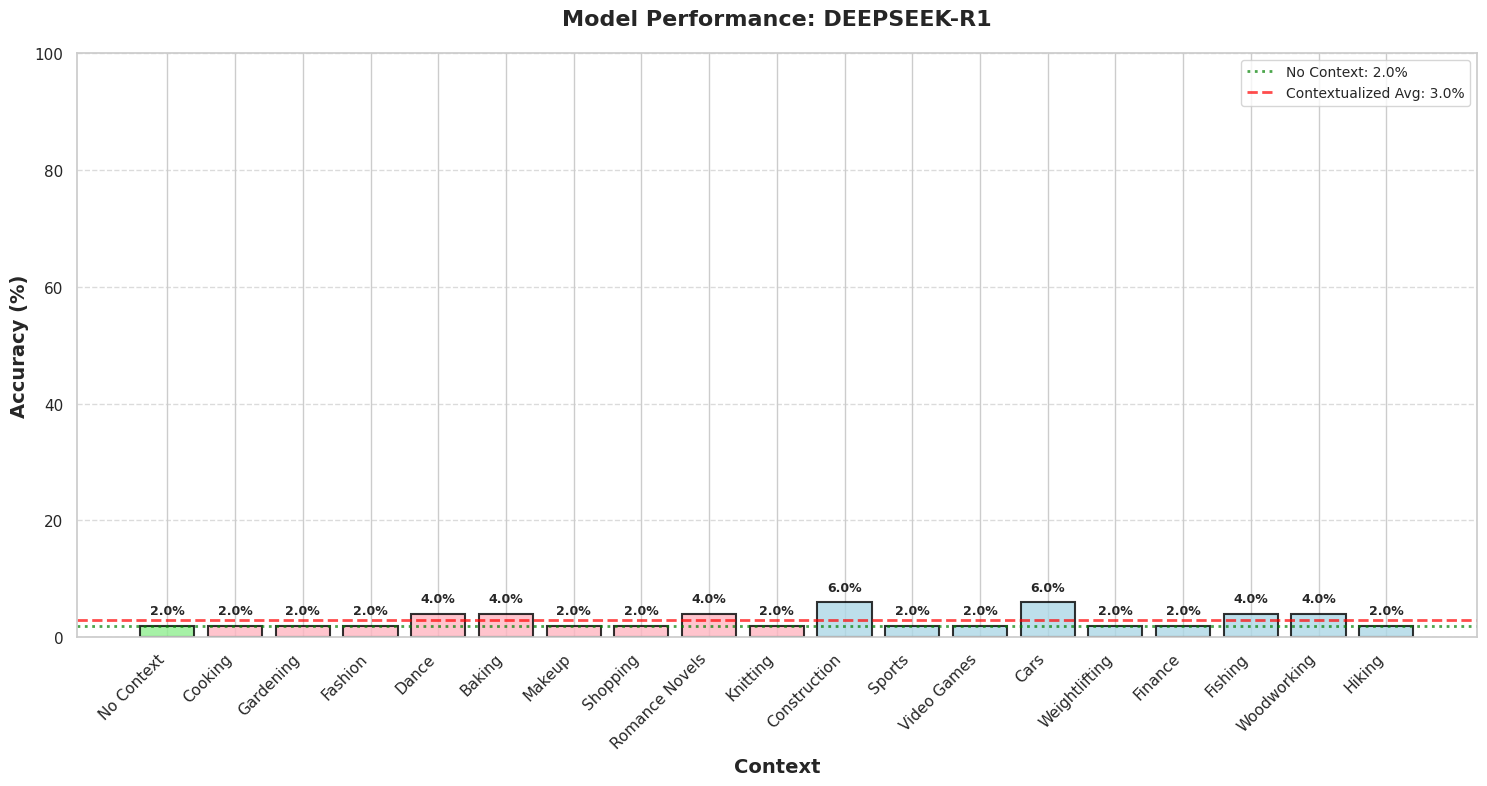



Completed! Generated 4 visualizations.


In [16]:
models = df['model'].unique()

print(f"Generating visualizations for {len(models)} models...\n")

figures = {}
for model in models:
    print(f"Creating plot for: {model}")
    fig = create_model_visualization(df, model)
    if fig:
        figures[model] = fig
        plt.show()
    print()

print(f"\nCompleted! Generated {len(figures)} visualizations.")

Saved comparison plot to: evaluation_results/plots/all_models_comparison.png


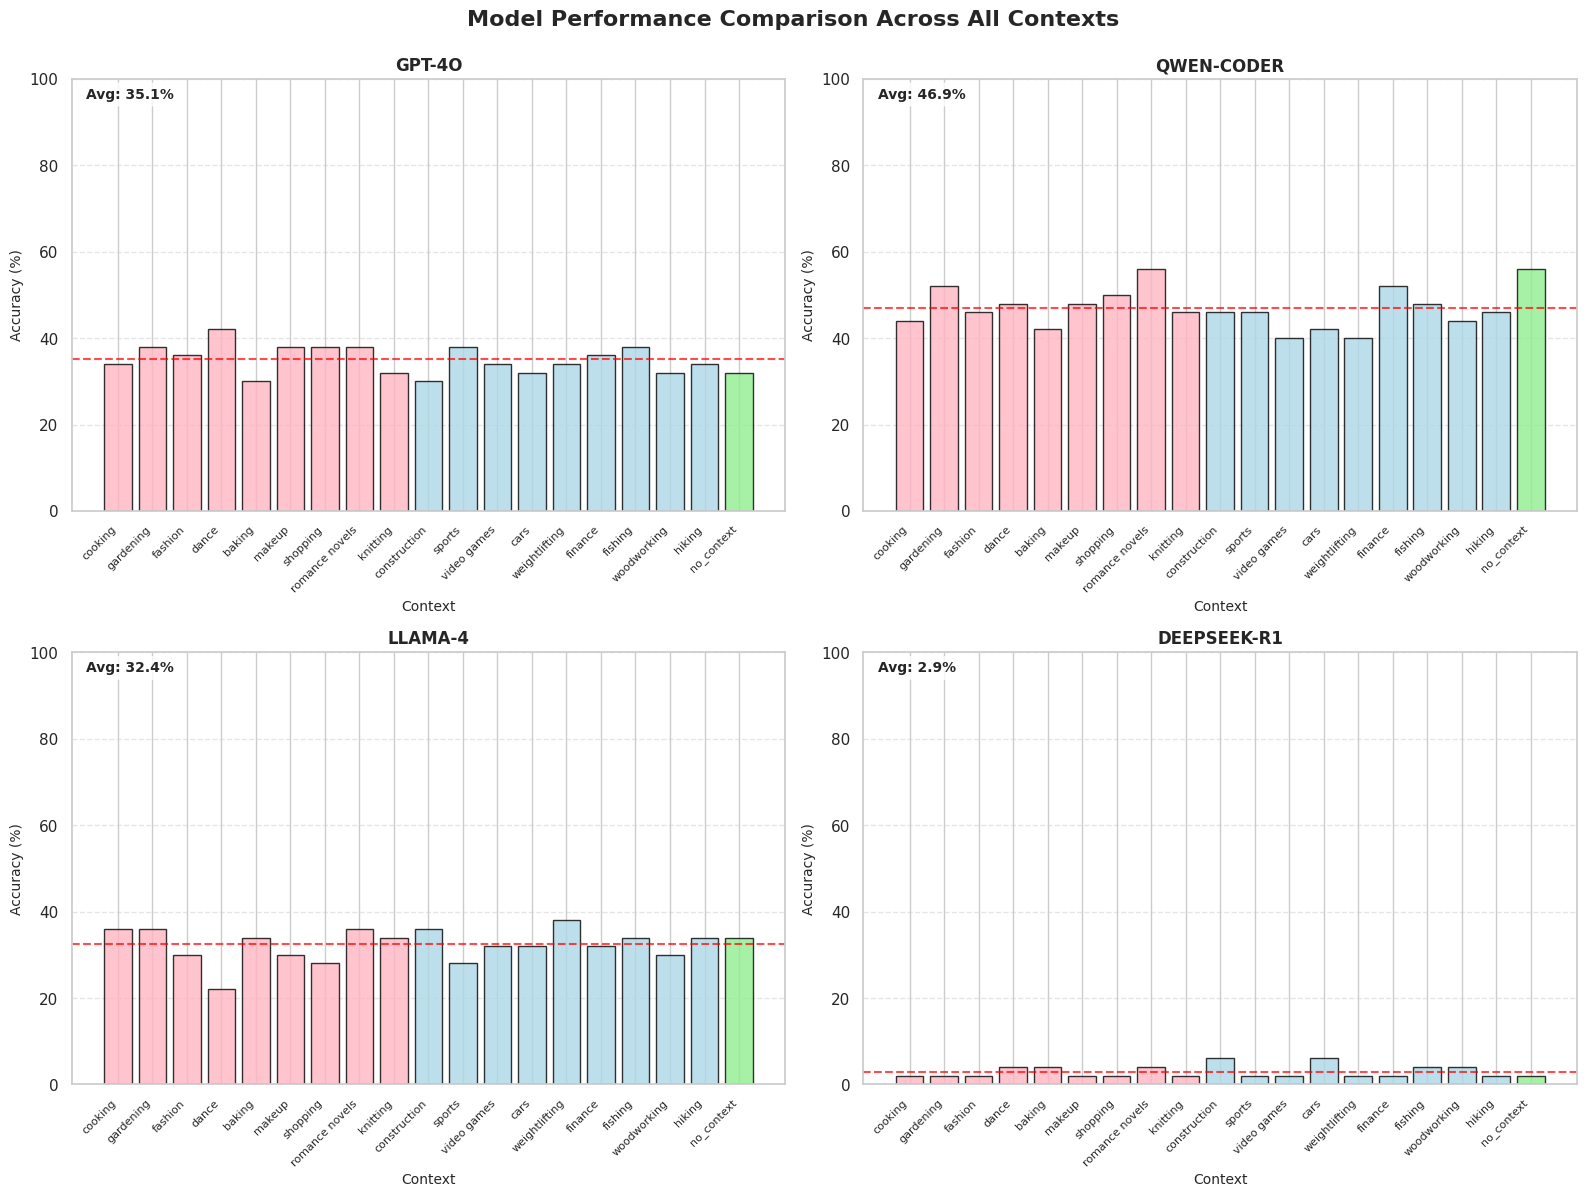

In [17]:
def create_comparison_plot(df, output_dir="evaluation_results/plots"):
    """Create a comparison plot showing all models side by side."""
    
    models = df['model'].unique()
    contexts = first_half_contexts + second_half_contexts
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, model in enumerate(models):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()
        
        # Sort by context order
        model_data['context_order'] = model_data['context'].apply(
            lambda x: contexts.index(x) if x in contexts else 999
        )
        model_data = model_data.sort_values('context_order')
        
        # Create bar plot
        ax.bar(range(len(model_data)), model_data['accuracy'], 
               color=model_data['color'], edgecolor='black', 
               linewidth=1, alpha=0.8)
        
        # Customize
        ax.set_title(f'{model.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Context', fontsize=10)
        ax.set_ylabel('Accuracy (%)', fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_xticks(range(len(model_data)))
        ax.set_xticklabels(model_data['context'], rotation=45, ha='right', fontsize=8)
        ax.yaxis.grid(True, linestyle='--', alpha=0.5)
        
        # Add average line
        avg = model_data['accuracy'].mean()
        ax.axhline(y=avg, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.text(0.02, 0.98, f'Avg: {avg:.1f}%', transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide unused subplots
    for idx in range(len(models), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Model Performance Comparison Across All Contexts', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'all_models_comparison.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved comparison plot to: {output_file}")
    
    return fig

comparison_fig = create_comparison_plot(df)
plt.show()

In [18]:
def create_summary_table(df):
    """Create a summary statistics table."""
    summary = df.groupby('model').agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        'total_questions': 'first'
    }).round(2)
    
    summary.columns = ['Mean Accuracy', 'Std Dev', 'Min Accuracy', 'Max Accuracy', 'Questions']
    summary = summary.sort_values('Mean Accuracy', ascending=False)
    
    return summary

summary_table = create_summary_table(df)
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(summary_table)
print("="*70)


SUMMARY STATISTICS
             Mean Accuracy  Std Dev  Min Accuracy  Max Accuracy  Questions
model                                                                     
qwen-coder           46.95     4.68          40.0          56.0         50
gpt-4o               35.05     3.29          30.0          42.0         50
llama-4              32.42     3.81          22.0          38.0         50
deepseek-r1           2.95     1.39           2.0           6.0         50


In [19]:
def analyze_context_comparison(df):
    """Compare no-context vs contextualized performance."""
    
    results = []
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        
        no_context_acc = model_data[model_data['context'] == 'no_context']['accuracy'].mean()
        
        first_half_acc = model_data[model_data['context'].isin(first_half_contexts)]['accuracy'].mean()
        second_half_acc = model_data[model_data['context'].isin(second_half_contexts)]['accuracy'].mean()
        
        all_contextualized_acc = model_data[model_data['context'] != 'no_context']['accuracy'].mean()
        
        results.append({
            'model': model,
            'No Context': no_context_acc,
            'Contextualized Avg': all_contextualized_acc,
            'Context Effect': no_context_acc - all_contextualized_acc,
            'Group 1 (Pink)': first_half_acc,
            'Group 2 (Blue)': second_half_acc,
            'Group Difference': first_half_acc - second_half_acc
        })
    
    return pd.DataFrame(results).round(2)

context_comparison = analyze_context_comparison(df)
print("\n" + "="*80)
print("NO-CONTEXT VS CONTEXTUALIZED COMPARISON")
print("="*80)
print(context_comparison)
print("="*80)
print("\nNote:")
print("- Positive 'Context Effect' means better on no-context questions")
print("- Negative 'Context Effect' means better on contextualized questions")
print("- Positive 'Group Difference' means better on Group 1 (Pink) contexts")


NO-CONTEXT VS CONTEXTUALIZED COMPARISON
         model  No Context  Contextualized Avg  Context Effect  \
0       gpt-4o        32.0               35.22           -3.22   
1   qwen-coder        56.0               46.44            9.56   
2      llama-4        34.0               32.33            1.67   
3  deepseek-r1         2.0                3.00           -1.00   

   Group 1 (Pink)  Group 2 (Blue)  Group Difference  
0           36.22           34.22              2.00  
1           48.00           44.89              3.11  
2           31.78           32.89             -1.11  
3            2.67            3.33             -0.67  

Note:
- Positive 'Context Effect' means better on no-context questions
- Negative 'Context Effect' means better on contextualized questions
- Positive 'Group Difference' means better on Group 1 (Pink) contexts


Saved comparison plot to: evaluation_results/plots/no_context_comparison.png


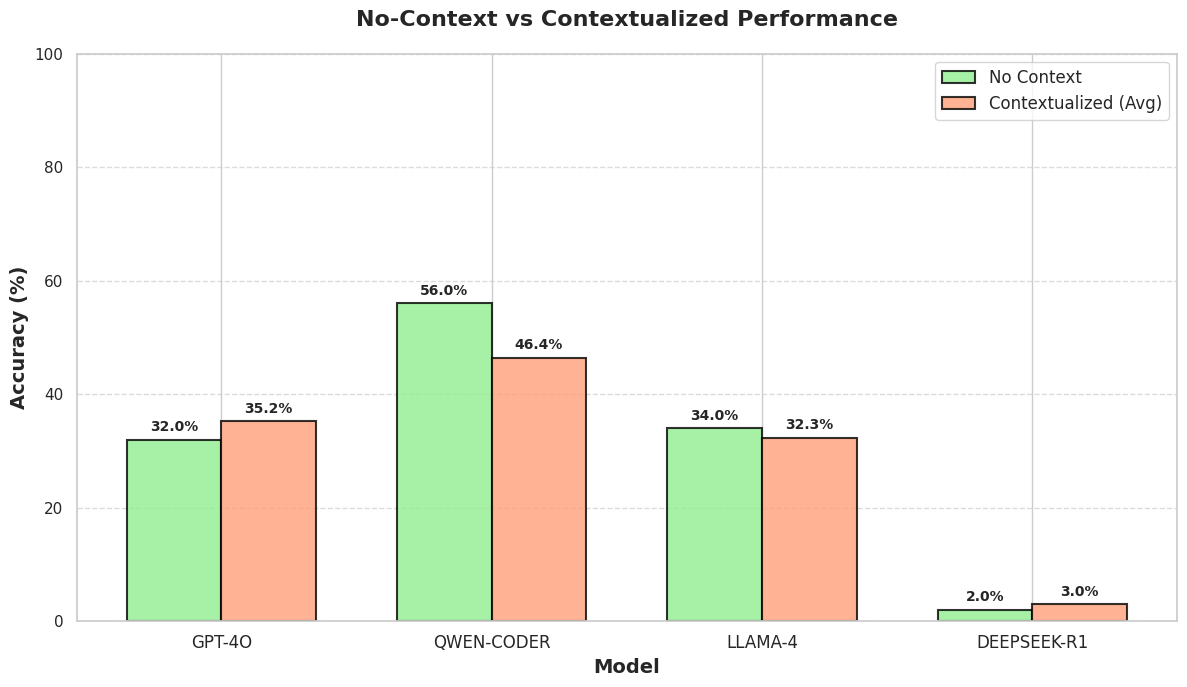

In [20]:
def create_no_context_comparison_plot(df, output_dir="evaluation_results/plots"):
    """Create bar plot comparing no-context vs contextualized performance."""
    
    models = df['model'].unique()
    comparison_data = []
    
    for model in models:
        model_data = df[df['model'] == model]
        
        no_context = model_data[model_data['context'] == 'no_context']['accuracy'].mean()
        contextualized = model_data[model_data['context'] != 'no_context']['accuracy'].mean()
        
        comparison_data.append({
            'model': model,
            'No Context': no_context,
            'Contextualized': contextualized
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comp_df['No Context'], width, 
                   label='No Context', color=no_context_color, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x + width/2, comp_df['Contextualized'], width,
                   label='Contextualized (Avg)', color='#FFA07A',
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Customize
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('No-Context vs Contextualized Performance', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend(fontsize=12, loc='upper right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'no_context_comparison.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved comparison plot to: {output_file}")
    
    return fig

no_context_fig = create_no_context_comparison_plot(df)
plt.show()

Saved three-way comparison plot to: evaluation_results/plots/three_way_comparison.png

THREE-WAY PERFORMANCE COMPARISON
      model  No Context  Group 1 (Pink)  Group 2 (Blue)
     gpt-4o        32.0       36.222222       34.222222
 qwen-coder        56.0       48.000000       44.888889
    llama-4        34.0       31.777778       32.888889
deepseek-r1         2.0        2.666667        3.333333


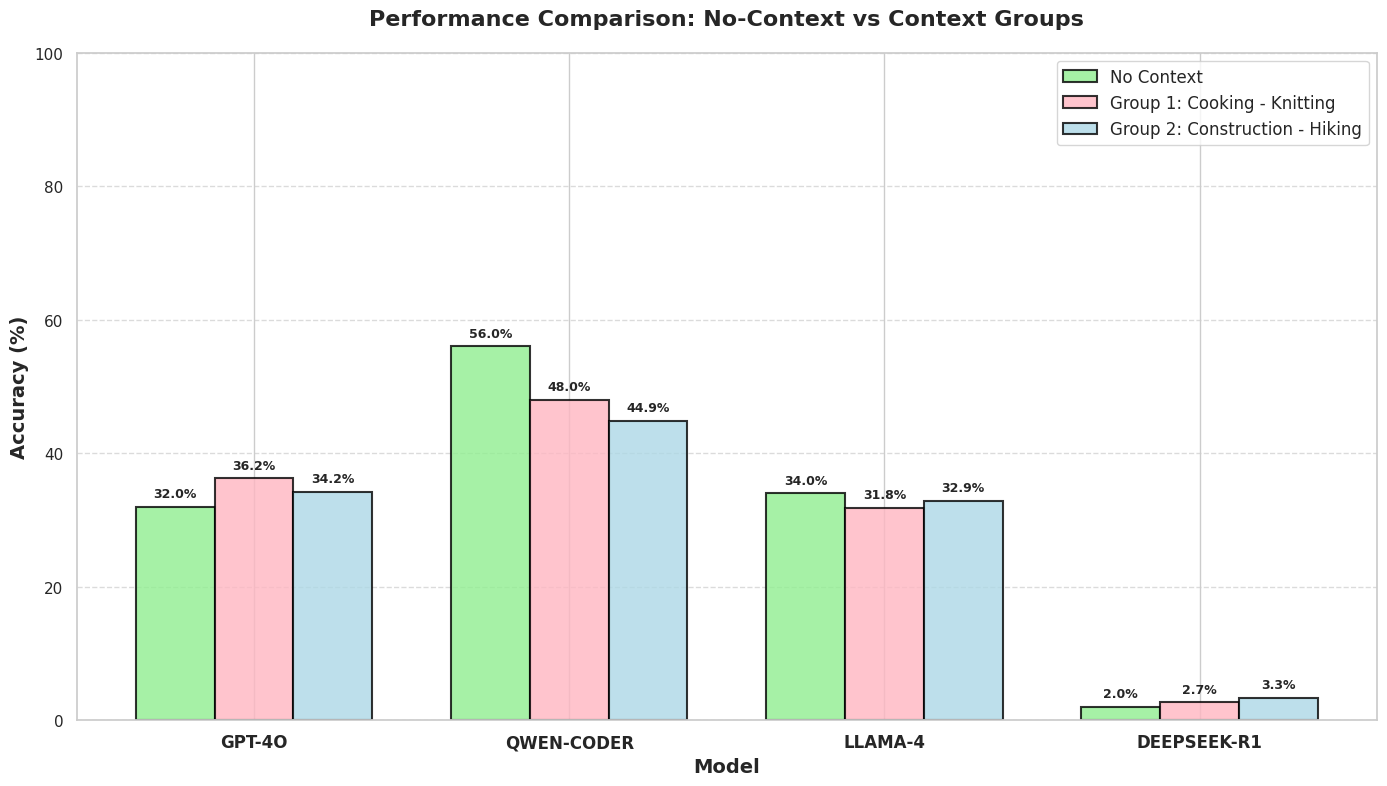

In [21]:
# Cell 11: Create three-way comparison visualization
def create_three_way_comparison_plot(df, output_dir="evaluation_results/plots"):
    """Create bar plot comparing no-context vs Group 1 (pink) vs Group 2 (blue) for each model."""
    
    models = df['model'].unique()
    comparison_data = []
    
    for model in models:
        model_data = df[df['model'] == model]
        
        no_context = model_data[model_data['context'] == 'no_context']['accuracy'].mean()
        group1_avg = model_data[model_data['context'].isin(first_half_contexts)]['accuracy'].mean()
        group2_avg = model_data[model_data['context'].isin(second_half_contexts)]['accuracy'].mean()
        
        comparison_data.append({
            'model': model,
            'No Context': no_context,
            'Group 1 (Pink)': group1_avg,
            'Group 2 (Blue)': group2_avg
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(models))
    width = 0.25
    
    bars1 = ax.bar(x - width, comp_df['No Context'], width, 
                   label='No Context', color=no_context_color, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x, comp_df['Group 1 (Pink)'], width,
                   label='Group 1: Cooking - Knitting', color=light_pink,
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    bars3 = ax.bar(x + width, comp_df['Group 2 (Blue)'], width,
                   label='Group 2: Construction - Hiking', color=light_blue,
                   edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Customize
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Performance Comparison: No-Context vs Context Groups', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in models], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.legend(fontsize=12, loc='upper right')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'three_way_comparison.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved three-way comparison plot to: {output_file}")
    
    # Print numerical comparison
    print("\n" + "="*80)
    print("THREE-WAY PERFORMANCE COMPARISON")
    print("="*80)
    print(comp_df.to_string(index=False))
    print("="*80)
    
    return fig

three_way_fig = create_three_way_comparison_plot(df)
plt.show()